Note: MIMIC III is a restricted dataset, so this notebook only shows aggregated values and does not come with the source datafile. To run the notebook, place the data file in your local directory and update the pd.read_csv path as needed.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
plt.rcParams.update({'font.size': 14, 'axes.titlesize': 14,
                     'figure.titlesize': 14})

The purpose of this notebook is to explore the distribution of the lengths of hospital stays and intra-admissions times for the MIMIC III database.

In [3]:
to_keep = ['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME', 'ADMISSION_TYPE']
df = pd.read_csv('data/ADMISSIONS.csv', parse_dates=['ADMITTIME', 'DISCHTIME']).loc[:,to_keep]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58976 entries, 0 to 58975
Data columns (total 5 columns):
SUBJECT_ID        58976 non-null int64
HADM_ID           58976 non-null int64
ADMITTIME         58976 non-null datetime64[ns]
DISCHTIME         58976 non-null datetime64[ns]
ADMISSION_TYPE    58976 non-null object
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 2.2+ MB


I will explore the distribution of number of visits per subject. First, see the below table that shows the cumulative number of patients (right column) that have had a given number of admissions (left column).

For example, 7537 patients have had 2 or more visits, while the other 46520 patients have had only 1 visit. 

In [5]:
df.groupby(['SUBJECT_ID'], as_index=False).count()['HADM_ID'].value_counts().sort_index(ascending=False).cumsum()

42        1
34        3
31        4
24        5
23        6
22        7
21        8
20        9
19       10
17       13
16       15
15       16
14       20
13       25
12       33
11       46
10       60
9        86
8       117
7       168
6       281
5       527
4      1035
3      2377
2      7537
1     46520
Name: HADM_ID, dtype: int64

Here is a histogram view of the actual (non-cumulative) distribution of patients with a given number of admissions. It is not very informative, except that most patients have only had one admission.

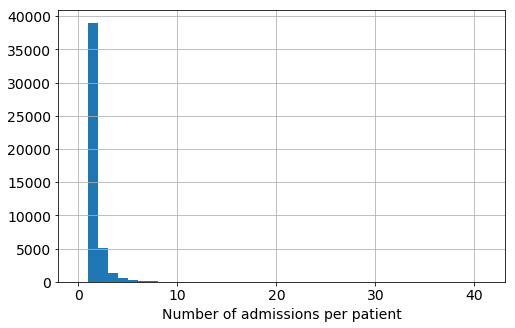

In [6]:
df.groupby(['SUBJECT_ID'], as_index=False).count()['HADM_ID'].hist(bins=range(42), figsize=(8,5))
plt.xlabel('Number of admissions per patient')
plt.show()

41 is the maximum number of admissions, but is not visible at this scale.

Next, I will drop all patients with only one admission. 

In [7]:
mult_admits = df.groupby(['SUBJECT_ID'], as_index=False).count()
mult_admits = set(mult_admits.loc[mult_admits['ADMITTIME'] > 1, :]['SUBJECT_ID'])
mult_admits_df = df.loc[df['SUBJECT_ID'].isin(mult_admits),:]

print(f'Number of samples remaining: {mult_admits_df.shape[0]}')

Number of samples remaining: 19993


We may also need to consider which types of admissions are relevent for our potential analysis. For now, I will keep all types of admissions.

In [8]:
mult_admits_df['ADMISSION_TYPE'].value_counts()

EMERGENCY    16654
ELECTIVE      2640
URGENT         439
NEWBORN        260
Name: ADMISSION_TYPE, dtype: int64

In [9]:
grp_df = mult_admits_df.groupby(['SUBJECT_ID'], as_index=False) \
                       .apply(lambda df : df.sort_values(by='ADMITTIME'))

Also evaluate distribution of lengths of stays for the subset of the dataset involving patients with multiple stays. 

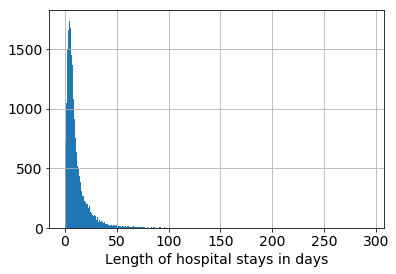

In [10]:
grp_df['ADMIT_LENGTH'] = (grp_df['DISCHTIME'] - grp_df['ADMITTIME']).apply(lambda x: x.days)

grp_df['ADMIT_LENGTH'].hist(bins=range(grp_df['ADMIT_LENGTH'].max()))
plt.xlabel('Length of hospital stays in days')
plt.show()

The data is skewed right but the vast majority of stays are within a small band of values. 

Now I will look at the time between sequential discharge-admission and discharge-discharge pairs. This will require dropping one row per subject because a subject with k admissions only has k-1 intra-visit intervals.

In [11]:
grp_df['LAST_DISCHTIME'] = grp_df.groupby('SUBJECT_ID', as_index=False)['DISCHTIME'] \
                                 .transform(lambda x : x.shift(1))
grp_df = grp_df.loc[grp_df['LAST_DISCHTIME'].notnull(),:]
print(f'Samples remaining: {grp_df.shape[0]}')

Samples remaining: 12456


Therefore, we end up with 12,456 samples remaining from an initial dataset of 58,956. 

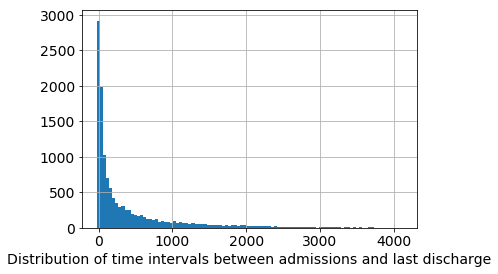

Min time interval: -19
Mean time interval: 404.0378933847142
Median time interval: 122.0
Max time interval: 4107


In [12]:
grp_df['ADMIT_TO_LAST_DISCH'] = (grp_df['ADMITTIME'] - grp_df['LAST_DISCHTIME']).apply(lambda x: x.days)
grp_df['DISCH_TO_LAST_DISCH'] = (grp_df['DISCHTIME'] - grp_df['LAST_DISCHTIME']).apply(lambda x: x.days)

dist_1 = grp_df['ADMIT_TO_LAST_DISCH']
dist_1.hist(bins=100)
plt.xlabel('Distribution of time intervals between admissions and last discharge')
plt.show()
print(f'Min time interval: {dist_1.min()}')
print(f'Mean time interval: {dist_1.mean()}')
print(f'Median time interval: {dist_1.median()}')
print(f'Max time interval: {dist_1.max()}')

I did not expect to find negative time durations between a current admission and the previous discharge. I investigated to see if I had made an error. There was no error, the cause is that sometimes a patient had multiple admission dates aligned with the same discharge date. 

e.g. <br> 
row 1 -> patient 1, admitted day 5, discharged day 10<br>
row 2 -> patient 1, admitted day 7, discharged day 10
     
I checked the MIMIC III documentation and could not find any explanation for patients having multiple admissions with the same discharge date. However, since we would likely want to predict ICD9 codes at discharge using data from a non-overlapping prior visit, I will drop all rows with negative time durations as irrelevant. 

In [13]:
grp_df = grp_df.loc[grp_df['ADMIT_TO_LAST_DISCH'] > 0,:]
print(f'Samples remaining: {grp_df.shape[0]}')

Samples remaining: 12294


Fortunately, the situation described above was rare and only resulted in a loss of 162 samples. Some of those may be recoverable, as I conservatively assumed that an interval = 0 was irrelevant, while further investigation might show some legitimate samples where admission, discharge, and readmission occured in less than whatever time rounds down to 0 days. 

I will replot the interval distributions now.

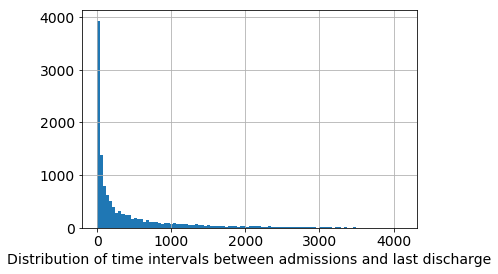

Min time interval: 1
Mean time interval: 409.3646494224825
Median time interval: 126.0
Max time interval: 4107


In [14]:
dist_1 = grp_df['ADMIT_TO_LAST_DISCH']
dist_1.hist(bins=100)
plt.xlabel('Distribution of time intervals between admissions and last discharge')
plt.show()
print(f'Min time interval: {dist_1.min()}')
print(f'Mean time interval: {dist_1.mean()}')
print(f'Median time interval: {dist_1.median()}')
print(f'Max time interval: {dist_1.max()}')

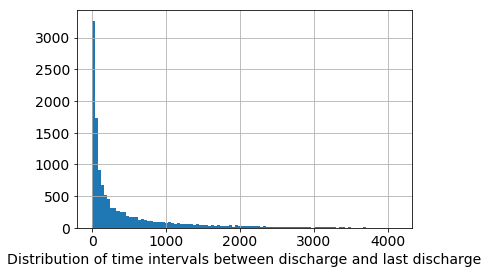

Min time interval: 1
Mean time interval: 419.5110623068163
Median time interval: 137.0
Max time interval: 4121


In [15]:
dist_2 = grp_df['DISCH_TO_LAST_DISCH']
dist_2.hist(bins=100)
plt.xlabel('Distribution of time intervals between discharge and last discharge')
plt.show()
print(f'Min time interval: {dist_2.min()}')
print(f'Mean time interval: {dist_2.mean()}')
print(f'Median time interval: {dist_2.median()}')
print(f'Max time interval: {dist_2.max()}')

I will assume that we will look at "observation windows" defined as a varying number of days prior to the current admission and see how many samples are retained at various window sizes.

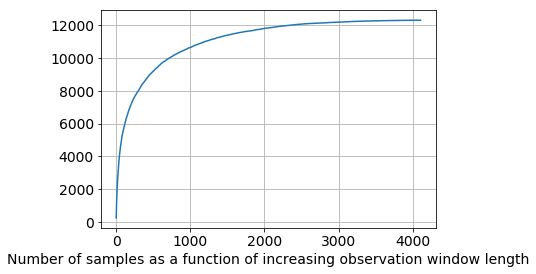

In [16]:
cum_samples = dist_1.value_counts().sort_index().cumsum()
plt.plot(cum_samples)
plt.xlabel('Number of samples as a function of increasing observation window length')
plt.grid()
plt.show()

While a longer observation window captures more samples, it also leads to potential for longer prediction windows. I will plot the distribution of prediction windows (discharge to discharge intervals) as a function of 100, 300, 1000, and 2000 day observation windows.

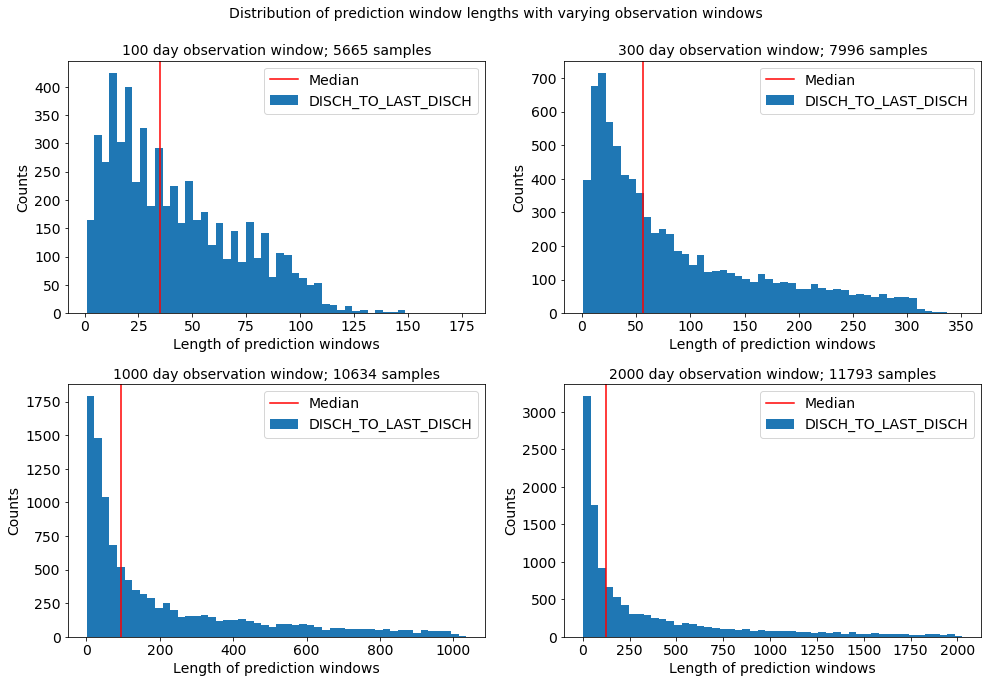

In [17]:
windows = [100, 300, 1000, 2000]
fig, axes = plt.subplots(2, 2, figsize=(14,10))
fig.suptitle("Distribution of prediction window lengths with varying observation windows", fontsize=14)
for i, window in enumerate(windows):
    ax = axes[i // 2, i % 2]
    dist = grp_df['DISCH_TO_LAST_DISCH'].loc[grp_df['ADMIT_TO_LAST_DISCH'] <= window]
    ax.hist(dist, bins=50)
    ax.set_title(f'{window} day observation window; {len(dist)} samples')
    ax.axvline(dist.median(), color='red', label='Median')
    ax.set_xlabel('Length of prediction windows')
    ax.set_ylabel('Counts')
    ax.legend()

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

**Conclusions:**

* We lose about 80% of the data by limiting to predictions on future events, due to the limited subset of samples that are return visits. We might want to run some basic models (SVMs, logistic regression) to see if we think its enough data to make predictions. Even then, it may be that CAML requires much more data than those methods so it could be hard to verify if ~10k is enough samples.
* If we want more control over the variance in observation and prediction windows, we further reduce our sample size as summarized in the plot above. However, ~50% of the samples have an observation window within 100 days and the median prediction window for those samples is only ~40 days. 
* Because of the skewed distribution of observation intervals, we quickly gain samples with increasing window size.